<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
import os; import subprocess

def detect_env():
    return 'colab' if 'content' in os.listdir('/') else 'IBM'
  
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
if detect_env() == 'colab': root_folder = '/content'
elif detect_env() == 'IBM' : root_folder = '/root/Derakhshani/adversarial'
python_files_path = root_folder + '/nag-public'

if os.path.isdir(python_files_path):
  initial_dir = os.getcwd()
  os.chdir(python_files_path)
  run_shell_command('git pull')
  os.chdir(initial_dir)
else:
  os.chdir('/root/Derakhshani/adversarial')
  run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')

Already up-to-date.



In [198]:
import sys
sys.path.append(python_files_path + '/NAG-11May-beforeDenoiser')

from nag_util import *
import nag_util
from environment import *

env = create_env()
env.setup(cuda_index = 1)

In [199]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [200]:
from functools import partial
from torch.nn import init
from typing import Iterable
torch.Tensor.ndim = property(lambda x: len(x.shape))

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

class ListContainer():
  def __init__(self, items): self.items = listify(items)
  def __getitem__(self, idx):
    if isinstance(idx, (int, slice)): return self.items[idx]
    if isinstance(idx[0], bool):
      assert len(idx) == len(self)
      return [o for m,o in zip(idx, self.items) if m]
    return [self.items[i] for i in idx]
  
  def __len__(self): return len(self.items)
  def __iter__(self): return iter(self.items)
  def __setitem__(self, i, o): self.items[i] = o
  def __delitem__(self, i): del(self.items[i])
  def __repr__(self):
    res = f"{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}"
    if len(self)>10: res = res[:-1] + "...]"
    return res

def children(m): return list(m.children())

def append_stats_non_normal(hook, mod, inp, outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[],[])
  means,stds,hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds .append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

def append_stats_normal(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

def get_hist(h):
  return torch.stack(h.stats[2]).t().float().log1p()

def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[:2].sum(0)/h1.sum(0)

class Hook():
  def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
  def __del__(self): self.remove()
  def remove(self): self.hook.remove()
    
class Hooks(ListContainer):
  def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms.children()])
  def __enter__(self, *args): return self
  def __exit__ (self, *args): self.remove()
  def __del__(self): self.remove()

  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)

  def remove(self):
    for h in self: h.remove()

def init_cnn_(m, f):
    if isinstance(m, nn.ConvTranspose2d):
      f(m.weight, a=0.1)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
        
    #non-orthogonal
    if isinstance(m, nn.Linear):
      f(m.weight, a=0.)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
        
    #orthogonal
#     if isinstance(m, nn.Linear):
#       init.orthogonal_(m.weight)
#       m.bias.data.zero_()

    for l in m.children(): init_cnn_(l, f)  
      
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [201]:
# mode = "sanity_check"
# mode = "normal"
mode = "div_metric_calc"

In [202]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [203]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [204]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [205]:
z_dim = 10
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [206]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.quarter = max(self.gf_dim // 4, 1)
#     self.eighth = max(self.gf_dim // 8, 1)
#     # sixteenth = max(self.gf_dim // 16, 1)
    
#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)
  
# #   # blind-selection
#   def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     for i in range(self.bs):
#       random_label = self.randint(0,1000, exclude = benign_preds[i].item())
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z

# #   #second-best selection: made validation so much worse
# #   def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     for i in range(self.bs):
# #       z[i][target_preds[i]] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
# #    def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
# #     for i in range(self.bs):
# #       z[i][random_label] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
#   @staticmethod
#   def randint(low, high, exclude):
#     temp = np.random.randint(low, high - 1)
#     if temp == exclude:
#       temp = temp + 1
#     return temp
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [207]:
# non-targeted Gen
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.half = max(self.gf_dim // 2, 1) 
    self.quarter = max(self.gf_dim // 4, 1)
    self.eighth = max(self.gf_dim // 8, 1)
    # sixteenth = max(self.gf_dim // 16, 1)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
#     p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
    z_out = self.forward_z(z)
#     p_out = self.forward_z(p)
#     n_out = self.forward_z(n)
    
#     return z_out, p_out, n_out, inputs
    return z_out, None, None, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)

In [208]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 in [0,1] : #and anchor.shape[1] == 1000:
    print("a: ", end=""); print_big_vector(anchor[0])
    print("p: ", end=""); print_big_vector(positive[0])
    print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [209]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

fool_loss_count = 0

def fool_loss(input, target):
  true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
  target_probabilities = input.gather(1, true_class)
  epsilon = 1e-10
  result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))
  
  global fool_loss_count
  fool_loss_count += 1
  if fool_loss_count % 40 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
  return result


# def fool_loss(model_output, target_labels):
#   target_labels = target_labels.view(-1, 1).long().cuda()
#   target_probabilities = model_output.gather(1, target_labels)
#   epsilon = 1e-10
#   # highest possible fool_loss is - log(1e-10) == 23
#   result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 20 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
#   return result

# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   perturbed_images = clean_images + perturbations
#   benign_preds = torch.argmax(arch(clean_images), 1)
#   adversary_preds = torch.argmax(arch(perturbed_images), 1)
#   return (benign_preds != adversary_preds).float().mean()

def validation(gen_output, target):
  perturbations, _, _, clean_images = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()


In [210]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
# #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
#     def forward(self, inp, target):
#       sigma_B, _, _, X_B, B_Y, z = inp

#       X_A = X_B + sigma_B
# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

#       chosen_labels = z.argmax(dim=1)
#       fooling_loss =  fool_loss(A_Y, chosen_labels)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       self.losses = [fooling_loss]
#       self.metrics = dict(zip(self.metric_names, [fooling_loss]))

#       return sum(self.losses)
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [211]:
#non-targeted FeatureLoss
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
#         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
        self.metric_names = ["fool_loss"] + ['div_loss'] # Maybe Gram
        self.triplet_weight = 4.
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
    
#     # triplet loss
#     def forward(self, inp, target):
#         sigma_B, sigma_pos, sigma_neg, X_B = inp

#         X_A = self.add_perturbation(X_B, sigma_B) 
#         X_A_pos = self.add_perturbation(X_B, sigma_pos)
#         X_A_neg = self.add_perturbation(X_B, sigma_neg) 
        
#         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
#         B_Y, _ = self.make_features(X_B)
#         A_Y, A_feat = self.make_features(X_A)
# #         _, S_feat = self.make_features(X_S)
#         pos_softmax, _ = self.make_features(X_A_pos)
#         neg_softmax, _ = self.make_features(X_A_neg)
        
#         fooling_loss =  fool_loss(A_Y, B_Y)
      
# #         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
#         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
# #         self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
# #         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss]))
#         self.losses = [fooling_loss] + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

#         return sum(self.losses)


#     #use two types of triplet losses
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 
#       X_A_pos = self.add_perturbation(X_B, sigma_pos)
#       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)
#       pos_softmax, _ = self.make_features(X_A_pos)
#       neg_softmax, _ = self.make_features(X_A_neg)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
#       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
#       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
#       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

#       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

#       return sum(self.losses)

    # just fooling and diversity
    def forward(self, inp, target):      
      sigma_B, sigma_pos, sigma_neg, X_B = inp

      X_A = self.add_perturbation(X_B, sigma_B) 

      X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

      B_Y, _ = self.make_features(X_B)
      A_Y, A_feat = self.make_features(X_A)
      _, S_feat = self.make_features(X_S)

      fooling_loss =  fool_loss(A_Y, B_Y)

      raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
      weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

      self.losses = [fooling_loss] + weighted_diversity_losses
      self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

      return sum(self.losses)
  
  
    def add_perturbation(self, inp, perturbation):
        return inp.add(perturbation)
  
    def add_perturbation_shuffled(self, inp, perturbation):
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [212]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [213]:
env.save_filename = 'resnet50_x'
# env.save_filename = 'resnet50_17'
# env.save_filename = 'vgg16_32'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [217]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)

learn = Learner(data, gen, loss_func = feat_loss, model_dir = env.get_learner_models_dir(), metrics=[validation], callback_fns=[LossMetrics, csv_logger])
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])

# load_starting_point(learn, model.__name__, z_dim)
# random_seed(42, True)

models_directory returned is:  models/43


In [218]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

load_filename = 'resnet50_41/resnet50_41_30'
# load_filename = 'resnet50_startpoint_1'
# load_filename = 'resnet50_28/resnet50_28_499'
# load_filename = 'investigate_resnet50_5/0/resnet50_3'
# load_filename = 'vgg16_30/vgg16_30_69'
# load_filename = 'vgg16_12-last'

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneralRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for c

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (50000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=10, out_features=7168, bias=True)
  (BN_): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): GeneralRelu()
  )
  (CT2d_2): deconv_layer(
   

In [219]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print("\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} \n\tsave filename: {}\n".format(
  mode, model.__name__, load_filename , env.save_filename
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: div_metric_calc 
	netw-under-attack: resnet50 
	load filename: resnet50_41/resnet50_41_30 
	save filename: resnet50_x

please MAKE SURE that the config is correct.


In [188]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [189]:
from distutils import dir_util 

def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
  os.mkdir(env.get_csv_dir() + results_dir)
  os.mkdir(env.get_models_dir() + results_dir)
  
  for setting_ind in range(n_settings):
    learn = None; gen = None; gc.collect()
    gen = Gen(z_dim = z_dim)
    init_cnn(gen, True)
    
    tmp_csv_filename =  env.temp_csv_path + '/' + results_dir + '/' + str(setting_ind)
    csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)
    
    learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation], model_dir = env.get_learner_models_dir(), callback_fns=[LossMetrics, csv_logger])
    saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
    saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

    learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
    shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
    
    model_dest = env.get_models_dir() + results_dir + '/' + str(setting_ind)
    os.mkdir(model_dest)
    dir_util.copy_tree(env.data_path/env.get_learner_models_dir(), model_dest)
    shutil.rmtree(env.data_path/env.get_learner_models_dir())  

In [164]:
# results_dir = 'investigate_resnet50_5'
# investigate_initial_settings(15, 4, lr = 1e-2, wd = 0., results_dir = results_dir)

In [165]:
# shutil.rmtree(env.get_models_dir() + results_dir)
# shutil.rmtree(env.get_csv_dir() + results_dir)

In [190]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])
  
learn.fit(40, lr=1e-2, wd = 0., callbacks=[saver_best, saver_every_epoch])

# # learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# learn.fit(60, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 
  
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/env.get_learner_models_dir(), env.get_models_path())
shutil.rmtree(env.data_path/env.get_learner_models_dir())

epoch,train_loss,valid_loss,validation,fool_loss,div_loss,time
0,1.155368,1.231075,0.785000,0.558433,0.672642,03:42
1,1.253271,1.314561,0.736000,0.673661,0.640900,03:41
2,1.093559,1.140989,0.794000,0.538084,0.602905,03:41
3,1.089224,1.159093,0.789000,0.528315,0.630777,03:41
4,1.096439,1.058297,0.789000,0.502022,0.556274,03:41
5,0.928203,1.017809,0.832000,0.436306,0.581503,03:40
6,0.830987,0.968843,0.826000,0.458205,0.510638,03:41
7,0.848434,0.933326,0.838000,0.419128,0.514197,03:41
8,0.837532,0.921409,0.833000,0.439182,0.482227,03:43
9,0.743245,0.927716,0.847000,0.407222,0.520494,03:41


target probs tensor([[1.5658e-05],
        [1.4127e-05],
        [7.3630e-01],
        [8.5456e-04],
        [9.9999e-01],
        [1.5943e-03],
        [7.8402e-04],
        [3.4098e-01],
        [9.4157e-01],
        [9.9871e-01],
        [3.3021e-01],
        [2.9667e-03],
        [5.2960e-06],
        [9.3623e-05],
        [5.9332e-05],
        [3.8781e-08]], device='cuda:1', grad_fn=<GatherBackward>), loss: 1.465660572052002: 
target probs tensor([[3.4759e-06],
        [9.9639e-01],
        [4.3931e-05],
        [9.5200e-02],
        [2.0358e-01],
        [4.0018e-01],
        [1.0762e-05],
        [7.3653e-08],
        [6.3045e-02],
        [3.0431e-04],
        [4.9312e-02],
        [1.1217e-05],
        [1.2093e-01],
        [5.2827e-03],
        [1.8028e-03],
        [8.4599e-08]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.4196333587169647: 
target probs tensor([[9.7785e-01],
        [1.0650e-02],
        [9.7614e-01],
        [1.3183e-02],
        [2.2373e-05],
    

target probs tensor([[5.6540e-01],
        [3.4532e-03],
        [3.6516e-07],
        [2.4532e-05],
        [6.9345e-02],
        [5.0669e-04],
        [3.6960e-05],
        [1.0215e-02],
        [4.3941e-01],
        [5.8424e-05],
        [9.5731e-05],
        [9.9996e-01],
        [5.1954e-02],
        [3.6801e-03],
        [6.8147e-04],
        [9.1999e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.8862848877906799: 
target probs tensor([[1.2342e-01],
        [3.6802e-05],
        [3.3206e-01],
        [1.9924e-01],
        [2.8821e-01],
        [4.0421e-01],
        [8.3368e-01],
        [2.7674e-02],
        [8.5238e-01],
        [3.3808e-04],
        [1.5895e-05],
        [4.8069e-09],
        [1.3146e-03],
        [7.5329e-01],
        [4.0827e-03],
        [2.2708e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.4383276402950287: 
target probs tensor([[9.6277e-01],
        [4.8543e-03],
        [6.2612e-01],
        [6.9871e-02],
        [1.9306e-02],
   

target probs tensor([[3.2870e-01],
        [8.4524e-01],
        [5.8802e-03],
        [1.2196e-05],
        [6.0264e-05],
        [2.8211e-01],
        [7.0775e-09],
        [9.1758e-01],
        [3.1505e-05],
        [4.4103e-01],
        [1.2955e-04],
        [2.4204e-06],
        [5.9471e-06],
        [1.0622e-02],
        [1.3750e-01],
        [1.3785e-04]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.3648914098739624: 
target probs tensor([[3.1989e-05],
        [6.3382e-03],
        [1.0537e-07],
        [1.2777e-05],
        [2.4435e-04],
        [7.7587e-03],
        [8.8056e-04],
        [1.7376e-04],
        [9.0256e-02],
        [3.1075e-05],
        [1.2928e-03],
        [1.1533e-05],
        [1.1946e-03],
        [1.9263e-07],
        [7.3276e-02],
        [2.8004e-03]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.01196997333317995: 
target probs tensor([[2.3643e-07],
        [1.7173e-04],
        [2.6862e-06],
        [4.9035e-04],
        [1.2945e-01],
  

target probs tensor([[1.4341e-01],
        [1.6565e-01],
        [2.6273e-05],
        [3.9727e-04],
        [9.7941e-07],
        [6.3323e-01],
        [3.4998e-01],
        [1.2196e-09],
        [9.8680e-04],
        [2.7121e-06],
        [8.2548e-02],
        [6.6106e-01],
        [8.8032e-01],
        [8.7476e-07],
        [5.6111e-06],
        [2.0011e-04]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.31639477610588074: 
target probs tensor([[1.3998e-02],
        [1.3500e-01],
        [1.4105e-03],
        [5.4666e-01],
        [4.5542e-06],
        [3.1375e-04],
        [1.1480e-01],
        [8.2502e-07],
        [3.5171e-01],
        [9.4693e-05],
        [1.0218e-01],
        [1.0605e-03],
        [9.5293e-05],
        [1.9042e-02],
        [4.6645e-02],
        [2.1776e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.12055997550487518: 
target probs tensor([[7.2260e-01],
        [1.4940e-05],
        [5.9062e-04],
        [1.9373e-03],
        [3.3898e-03],
 

target probs tensor([[4.5718e-08],
        [7.3172e-01],
        [2.7461e-02],
        [2.0485e-06],
        [2.0786e-05],
        [2.6290e-09],
        [4.3713e-07],
        [4.8760e-01],
        [2.7378e-02],
        [9.1207e-01],
        [7.6453e-04],
        [7.3529e-02],
        [8.0067e-08],
        [9.0292e-01],
        [1.2139e-04],
        [3.5003e-02]], device='cuda:1'), loss: 0.432267427444458: 
target probs tensor([[1.7820e-03],
        [2.8444e-04],
        [2.9379e-01],
        [2.5326e-06],
        [3.5696e-04],
        [9.8456e-01],
        [1.0782e-02],
        [8.1212e-01],
        [1.9068e-01],
        [1.4391e-05],
        [8.4323e-04],
        [9.9572e-01],
        [1.6926e-03],
        [9.7720e-02],
        [7.9504e-03],
        [1.3044e-04]], device='cuda:1'), loss: 0.7489680647850037: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


target probs tensor([[7.082

target probs tensor([[3.0467e-07],
        [1.1203e-07],
        [1.9982e-02],
        [4.7801e-05],
        [1.6186e-05],
        [6.9926e-04],
        [1.0817e-07],
        [9.9842e-01],
        [1.3132e-02],
        [9.3255e-08],
        [1.3217e-08],
        [1.0055e-02],
        [7.1779e-01],
        [8.8188e-04],
        [2.1991e-08],
        [5.6402e-08]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.4849187433719635: 
target probs tensor([[1.7056e-10],
        [4.0251e-05],
        [3.3596e-01],
        [5.2716e-05],
        [2.5774e-06],
        [4.5129e-06],
        [3.4336e-05],
        [5.0872e-02],
        [8.2282e-01],
        [9.9889e-01],
        [2.9175e-04],
        [1.2246e-06],
        [6.6906e-03],
        [1.6964e-01],
        [1.3482e-06],
        [9.0421e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.7207032442092896: 
target probs tensor([[6.3882e-01],
        [8.0191e-01],
        [4.0277e-06],
        [1.7669e-01],
        [1.1577e-05],
   

target probs tensor([[3.8544e-04],
        [3.2421e-05],
        [1.2941e-04],
        [1.0073e-04],
        [5.9984e-05],
        [4.2896e-05],
        [4.1508e-13],
        [2.2946e-03],
        [2.7658e-04],
        [9.3545e-05],
        [1.0041e-01],
        [6.4017e-07],
        [8.9170e-03],
        [4.2816e-01],
        [3.5925e-09],
        [1.7165e-02]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.04339990392327309: 
target probs tensor([[9.7516e-01],
        [5.1852e-04],
        [1.1140e-08],
        [8.6180e-06],
        [1.5486e-10],
        [8.4505e-06],
        [9.7616e-01],
        [7.0877e-01],
        [6.5241e-03],
        [3.9790e-04],
        [1.5727e-06],
        [6.2175e-04],
        [4.1427e-01],
        [1.5447e-09],
        [4.0852e-10],
        [3.1007e-05]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.575503945350647: 
target probs tensor([[1.6507e-07],
        [1.2667e-03],
        [1.0103e-09],
        [4.4485e-10],
        [2.0778e-09],
   

target probs tensor([[6.9302e-03],
        [7.8340e-02],
        [3.8096e-04],
        [5.7512e-06],
        [5.3622e-11],
        [3.1875e-02],
        [6.0544e-15],
        [3.4212e-01],
        [3.3866e-01],
        [1.0278e-03],
        [2.8138e-07],
        [1.5991e-01],
        [3.7406e-07],
        [1.0211e-03],
        [9.2891e-10],
        [1.8781e-09]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.07061398029327393: 
target probs tensor([[2.6079e-06],
        [6.1221e-09],
        [8.6317e-06],
        [1.0549e-02],
        [7.7374e-02],
        [5.6249e-03],
        [2.6888e-02],
        [4.6975e-03],
        [2.0729e-03],
        [3.0019e-02],
        [1.6957e-01],
        [3.2847e-08],
        [1.8718e-04],
        [1.1692e-02],
        [2.6355e-07],
        [1.3481e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.03149240091443062: 
target probs tensor([[9.6904e-01],
        [4.6594e-02],
        [5.6710e-12],
        [7.5202e-03],
        [4.6842e-02],
 

target probs tensor([[2.9699e-02],
        [8.2909e-14],
        [1.0217e-13],
        [1.2042e-01],
        [5.7604e-06],
        [2.8722e-11],
        [3.0779e-03],
        [1.4588e-08],
        [5.1680e-10],
        [3.6736e-08],
        [6.9116e-09],
        [1.1953e-03],
        [1.1388e-07],
        [1.4928e-02],
        [2.5679e-01],
        [5.1663e-05]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.029663480818271637: 
target probs tensor([[8.0578e-08],
        [3.0867e-02],
        [1.9261e-03],
        [6.3350e-05],
        [8.1575e-07],
        [8.8192e-01],
        [6.0571e-08],
        [1.5915e-01],
        [2.7124e-06],
        [2.6178e-04],
        [9.7127e-05],
        [2.1119e-08],
        [3.6276e-06],
        [6.8770e-05],
        [8.9925e-01],
        [3.2600e-06]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.2899136245250702: 
target probs tensor([[2.1045e-07],
        [1.3111e-02],
        [2.1243e-05],
        [9.9567e-05],
        [5.5846e-05],
 

input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


target probs tensor([[1.3285e-05],
        [3.2448e-05],
        [3.1382e-04],
        [4.9198e-06],
        [1.8084e-03],
        [2.2793e-04],
        [3.0213e-07],
        [5.1306e-07],
        [1.4403e-02],
        [1.0000e+00],
        [6.1011e-04],
        [2.9882e-05],
        [2.5959e-03],
        [9.0965e-08],
        [9.2893e-03],
        [9.0056e-06]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.8332974314689636: 
target probs tensor([[3.8799e-06],
        [2.3606e-08],
        [4.6643e-03],
        [1.7335e-07],
        [3.0020e-02],
        [4.3718e-01],
        [3.7973e-05],
        [5.9257e-03],
        [2.2562e-04],
        [4.3445e-11],
        [4.7470e-10],
        [9.6320e-01],
        [1.8688e-09],
        [8.6169e-05],
        [5.4448e-11],
        [6.8875e-04]], device='cuda:1', grad_fn=<GatherBackward>), l

target probs tensor([[9.9809e-01],
        [9.0584e-03],
        [1.4711e-07],
        [5.7318e-01],
        [1.2532e-04],
        [1.2394e-02],
        [1.7012e-01],
        [2.5832e-07],
        [8.5278e-01],
        [6.9992e-12],
        [4.4581e-04],
        [1.0875e-07],
        [1.3018e-02],
        [1.5872e-05],
        [9.3943e-01],
        [5.0385e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.7970325946807861: 
target probs tensor([[7.6871e-03],
        [6.5906e-02],
        [6.6438e-15],
        [3.4803e-06],
        [9.8857e-07],
        [1.4268e-10],
        [9.9815e-01],
        [1.6985e-14],
        [9.9076e-07],
        [2.7746e-03],
        [1.1111e-10],
        [1.5741e-10],
        [9.5126e-01],
        [1.7620e-03],
        [2.1654e-06],
        [4.8339e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.6282778382301331: 
target probs tensor([[2.5238e-02],
        [3.3559e-04],
        [1.0447e-02],
        [8.6361e-06],
        [2.1374e-06],
   

target probs tensor([[7.6813e-06],
        [7.3481e-08],
        [8.2042e-01],
        [2.3066e-02],
        [1.1982e-02],
        [3.3021e-11],
        [1.5980e-06],
        [4.7129e-11],
        [1.8256e-08],
        [2.6208e-05],
        [2.7589e-02],
        [8.1090e-11],
        [9.9410e-01],
        [9.9907e-01],
        [5.3542e-07],
        [1.4032e-14]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.8686248064041138: 
target probs tensor([[3.1453e-05],
        [1.6834e-02],
        [1.4831e-04],
        [7.0745e-09],
        [1.1574e-05],
        [1.8449e-06],
        [6.5844e-08],
        [1.0409e-04],
        [2.1975e-02],
        [8.5178e-08],
        [3.5737e-09],
        [3.2685e-03],
        [6.9145e-04],
        [1.5604e-04],
        [9.4442e-01],
        [8.2662e-06]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.18335162103176117: 
target probs tensor([[9.8422e-01],
        [1.2352e-17],
        [1.9249e-07],
        [2.6530e-11],
        [3.3423e-01],
  

target probs tensor([[2.2019e-09],
        [3.9199e-01],
        [4.4178e-07],
        [3.6299e-07],
        [1.3187e-04],
        [1.4089e-03],
        [2.7434e-04],
        [3.6193e-02],
        [9.8364e-06],
        [8.8961e-11],
        [4.9826e-06],
        [1.5325e-07],
        [6.7452e-02],
        [2.4019e-02],
        [1.4983e-09],
        [2.2554e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.05537474900484085: 
target probs tensor([[7.8928e-08],
        [8.7685e-01],
        [2.4683e-06],
        [1.0613e-05],
        [1.4921e-02],
        [1.7086e-04],
        [5.7351e-03],
        [3.1880e-03],
        [1.4570e-03],
        [1.8612e-05],
        [1.7969e-08],
        [5.2625e-03],
        [9.1432e-08],
        [1.9089e-05],
        [1.9067e-07],
        [2.2717e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.14893826842308044: 
target probs tensor([[1.7172e-01],
        [1.1037e-02],
        [2.3647e-06],
        [3.0116e-07],
        [2.1478e-03],
 

target probs tensor([[3.3181e-04],
        [6.8080e-12],
        [5.3743e-01],
        [1.0273e-09],
        [9.6811e-06],
        [1.8599e-12],
        [5.5422e-06],
        [4.3758e-09],
        [2.2397e-01],
        [8.9464e-07],
        [2.0553e-02],
        [2.6259e-04],
        [4.7952e-08],
        [4.0968e-06],
        [1.5129e-03],
        [2.6314e-06]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.06546344608068466: 
target probs tensor([[9.0110e-06],
        [5.6467e-14],
        [1.0317e-04],
        [2.4004e-11],
        [2.7274e-12],
        [6.6363e-13],
        [4.6209e-02],
        [1.2515e-08],
        [7.6945e-04],
        [8.7812e-07],
        [3.9663e-07],
        [2.1390e-03],
        [2.5771e-07],
        [1.6050e-08],
        [1.5444e-05],
        [4.3464e-09]], device='cuda:1'), loss: 0.003146943636238575: 
target probs tensor([[4.0349e-06],
        [1.9021e-08],
        [1.1593e-06],
        [1.3418e-03],
        [2.0526e-03],
        [1.1870e-04],
    

target probs tensor([[6.4239e-01],
        [5.8917e-07],
        [6.6601e-05],
        [3.3565e-10],
        [2.1426e-02],
        [5.6239e-02],
        [1.8002e-13],
        [2.5068e-05],
        [1.3528e-04],
        [7.6036e-06],
        [1.1305e-10],
        [1.5382e-01],
        [1.2546e-06],
        [1.2802e-04],
        [2.1232e-10],
        [1.4967e-04]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.07971224933862686: 
target probs tensor([[3.4746e-03],
        [1.9169e-05],
        [8.6641e-06],
        [2.6224e-02],
        [2.5040e-07],
        [8.2015e-06],
        [5.3259e-14],
        [3.9208e-01],
        [1.6527e-04],
        [2.0464e-06],
        [3.6359e-05],
        [4.3323e-13],
        [9.1254e-03],
        [9.4381e-04],
        [5.9199e-02],
        [2.9965e-03]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.03763347119092941: 
target probs tensor([[9.3802e-06],
        [4.9498e-07],
        [1.1950e-04],
        [1.4660e-02],
        [3.4718e-14],
 

target probs tensor([[1.0146e-10],
        [1.5744e-10],
        [7.0396e-04],
        [6.4931e-06],
        [2.2980e-10],
        [1.5532e-03],
        [6.7287e-12],
        [2.2946e-03],
        [1.6045e-05],
        [4.4376e-02],
        [1.0187e-15],
        [1.1936e-12],
        [1.1418e-01],
        [6.8539e-01],
        [1.6493e-09],
        [4.4148e-06]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.0829768106341362: 
target probs tensor([[9.5722e-08],
        [1.1383e-02],
        [4.9143e-09],
        [1.6161e-09],
        [8.8559e-02],
        [1.2113e-10],
        [9.2102e-01],
        [1.5443e-09],
        [5.1111e-05],
        [1.2976e-08],
        [4.5402e-05],
        [9.8170e-01],
        [1.0173e-06],
        [3.6497e-08],
        [9.9902e-01],
        [3.0763e-08]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.8479492664337158: 
target probs tensor([[9.9152e-01],
        [1.4781e-06],
        [2.4822e-04],
        [9.0233e-02],
        [3.8520e-10],
   

target probs tensor([[3.0977e-11],
        [5.6266e-06],
        [8.1813e-12],
        [7.9556e-01],
        [5.7048e-09],
        [3.9715e-11],
        [7.0120e-02],
        [5.8469e-01],
        [1.0874e-03],
        [9.7945e-01],
        [1.0710e-03],
        [9.1050e-04],
        [2.1644e-01],
        [5.0856e-07],
        [4.9464e-05],
        [1.9855e-07]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.4169274568557739: 
target probs tensor([[1.3050e-07],
        [1.9145e-06],
        [1.6250e-01],
        [6.4494e-06],
        [1.9523e-02],
        [1.0436e-03],
        [1.8460e-06],
        [8.9219e-01],
        [7.0593e-01],
        [4.0619e-01],
        [1.3335e-03],
        [2.9985e-03],
        [4.8984e-08],
        [7.7167e-04],
        [2.1445e-06],
        [2.9944e-02]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.2628827393054962: 
target probs tensor([[1.5868e-06],
        [6.8983e-04],
        [2.9741e-09],
        [6.3663e-01],
        [1.5088e-02],
   

target probs tensor([[5.9878e-05],
        [1.1212e-04],
        [5.7559e-11],
        [1.1933e-04],
        [1.0123e-01],
        [3.1156e-03],
        [8.4147e-05],
        [7.1001e-04],
        [5.2581e-11],
        [5.9693e-06],
        [2.1361e-13],
        [1.6780e-01],
        [4.7114e-06],
        [7.5560e-06],
        [6.5795e-12],
        [8.3565e-03]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.018938619643449783: 
target probs tensor([[8.3675e-16],
        [3.3513e-03],
        [6.8675e-13],
        [6.7208e-01],
        [1.7933e-12],
        [5.9666e-05],
        [9.9251e-01],
        [5.7799e-05],
        [5.9009e-06],
        [3.6419e-09],
        [6.2123e-06],
        [1.5992e-04],
        [7.0291e-05],
        [1.8373e-10],
        [3.8175e-18],
        [1.4574e-08]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.375800758600235: 
target probs tensor([[1.7650e-09],
        [3.5037e-05],
        [2.5447e-05],
        [1.0485e-04],
        [1.6883e-05],
  

target probs tensor([[1.3053e-01],
        [2.4196e-06],
        [9.5829e-01],
        [3.0509e-02],
        [3.1937e-05],
        [3.3302e-01],
        [1.3944e-02],
        [9.9247e-07],
        [9.9888e-01],
        [3.9995e-07],
        [1.4246e-05],
        [4.3117e-05],
        [9.1193e-01],
        [6.0595e-06],
        [8.8768e-09],
        [3.3401e-02]], device='cuda:1'), loss: 0.8141632080078125: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


target probs tensor([[1.0851e-11],
        [1.0758e-02],
        [4.0946e-01],
        [4.7142e-03],
        [6.9350e-04],
        [5.9754e-07],
        [5.3356e-17],
        [1.5203e-04],
        [9.3075e-01],
        [1.7434e-08],
        [1.5924e-03],
        [2.9049e-08],
        [2.5849e-02],
        [5.3287e-02],
        [4.7614e-05],
        [1.4273e-05]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.2059854120016098: 


target probs tensor([[6.7282e-07],
        [9.5240e-01],
        [4.5740e-08],
        [7.5468e-01],
        [7.4069e-01],
        [7.7270e-08],
        [2.2869e-12],
        [3.6806e-16],
        [2.4110e-01],
        [6.5095e-05],
        [1.2235e-05],
        [1.3967e-06],
        [1.3029e-01],
        [4.1196e-05],
        [2.6549e-04],
        [1.5031e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.39866316318511963: 
target probs tensor([[1.0052e-01],
        [4.2715e-06],
        [2.2190e-03],
        [3.4870e-09],
        [2.9352e-01],
        [1.0914e-15],
        [2.5918e-01],
        [6.7231e-07],
        [7.9202e-05],
        [2.3574e-05],
        [9.6705e-07],
        [9.0424e-01],
        [1.8974e-07],
        [2.2794e-05],
        [6.9116e-13],
        [2.1115e-03]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.1939832866191864: 
target probs tensor([[1.0961e-03],
        [2.1149e-04],
        [3.4618e-03],
        [9.9814e-01],
        [3.1192e-07],
  

target probs tensor([[1.3404e-05],
        [9.4638e-09],
        [5.1911e-02],
        [1.0181e-02],
        [6.7452e-02],
        [1.7995e-01],
        [5.2865e-07],
        [2.1835e-01],
        [1.6997e-01],
        [2.6826e-07],
        [6.5636e-03],
        [1.8974e-04],
        [4.1151e-01],
        [3.3403e-01],
        [1.2082e-11],
        [6.6114e-08]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.10674318671226501: 
target probs tensor([[1.1201e-06],
        [2.2631e-11],
        [2.0838e-07],
        [3.1828e-04],
        [6.5032e-01],
        [2.0721e-08],
        [1.4485e-04],
        [8.3468e-04],
        [5.9121e-13],
        [1.8652e-05],
        [5.7838e-05],
        [3.9298e-04],
        [2.0207e-09],
        [2.5374e-01],
        [2.5075e-07],
        [1.3295e-07]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.08407364785671234: 
target probs tensor([[5.0907e-08],
        [3.5803e-03],
        [1.1550e-01],
        [1.0523e-09],
        [2.3841e-12],
 

target probs tensor([[2.8872e-13],
        [1.4315e-04],
        [8.6389e-04],
        [5.0328e-14],
        [9.9572e-02],
        [3.1399e-05],
        [2.3746e-03],
        [3.5973e-04],
        [3.2599e-14],
        [3.8529e-05],
        [1.5066e-03],
        [1.7808e-06],
        [1.2731e-01],
        [7.2551e-05],
        [4.5332e-08],
        [1.8755e-10]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.015403792262077332: 
target probs tensor([[1.1679e-04],
        [8.9267e-01],
        [3.9059e-01],
        [3.2928e-01],
        [1.9929e-05],
        [5.1699e-05],
        [2.0879e-09],
        [9.2434e-14],
        [1.2136e-13],
        [2.3652e-02],
        [9.9920e-01],
        [8.3418e-01],
        [5.3080e-04],
        [7.2081e-01],
        [4.4015e-01],
        [5.5317e-07]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.8709802627563477: 
target probs tensor([[3.1077e-06],
        [1.7211e-14],
        [4.9928e-03],
        [7.1839e-04],
        [1.0524e-04],
 

target probs tensor([[3.9973e-12],
        [4.3382e-08],
        [4.2969e-07],
        [1.2660e-10],
        [1.0015e-14],
        [6.1062e-05],
        [6.3864e-19],
        [6.7154e-11],
        [1.7250e-14],
        [2.6324e-08],
        [2.6837e-02],
        [1.9657e-10],
        [4.8881e-01],
        [4.3617e-06],
        [6.6373e-01],
        [1.4110e-10]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.11175812780857086: 
target probs tensor([[2.1795e-16],
        [2.2200e-10],
        [1.6238e-05],
        [1.8757e-07],
        [7.6778e-02],
        [1.4090e-01],
        [5.4976e-04],
        [1.5566e-08],
        [1.6902e-04],
        [3.4093e-07],
        [1.3649e-04],
        [5.6343e-06],
        [1.0313e-06],
        [1.2714e-07],
        [8.4083e-01],
        [6.9866e-07]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.12940223515033722: 
target probs tensor([[4.8807e-11],
        [3.8326e-01],
        [1.5198e-04],
        [1.3682e-15],
        [1.0213e-05],
 

input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


target probs tensor([[2.6108e-04],
        [5.8542e-04],
        [7.7791e-12],
        [2.1632e-07],
        [1.5229e-05],
        [6.6824e-06],
        [1.0082e-07],
        [3.5918e-08],
        [1.2750e-01],
        [4.0004e-04],
        [1.7534e-11],
        [1.7996e-02],
        [7.6220e-02],
        [3.5518e-06],
        [7.8498e-05],
        [6.9867e-05]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.014703387394547462: 
target probs tensor([[3.1244e-08],
        [2.2186e-06],
        [1.0171e-14],
        [2.7223e-03],
        [2.8465e-09],
        [1.6514e-02],
        [3.2755e-07],
        [1.6014e-03],
        [6.8355e-01],
        [7.3395e-08],
        [1.2670e-06],
        [9.4380e-01],
        [2.4229e-08],
        [2.6418e-14],
        [1.2009e-13],
        [3.0242e-05]], device='cuda:1', grad_fn=<GatherBackward>),

target probs tensor([[8.8181e-04],
        [5.3462e-08],
        [3.9915e-06],
        [1.2993e-03],
        [1.1696e-04],
        [1.7951e-01],
        [8.1394e-01],
        [3.5261e-02],
        [1.3192e-01],
        [1.2101e-03],
        [2.2502e-03],
        [5.3189e-12],
        [7.3608e-01],
        [1.9697e-01],
        [1.5902e-04],
        [4.1836e-07]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.2258950173854828: 
target probs tensor([[9.9160e-01],
        [2.4861e-05],
        [1.1690e-04],
        [4.4148e-04],
        [1.0736e-04],
        [7.0055e-03],
        [5.1021e-03],
        [1.0137e-05],
        [1.4013e-13],
        [1.2541e-01],
        [4.1652e-02],
        [2.2429e-06],
        [6.1156e-06],
        [7.7027e-01],
        [1.2258e-10],
        [4.3894e-02]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.40525445342063904: 
target probs tensor([[1.5561e-03],
        [7.9276e-05],
        [8.9824e-03],
        [3.5874e-03],
        [1.1236e-05],
  

target probs tensor([[1.3724e-03],
        [3.5897e-08],
        [7.4168e-09],
        [1.8595e-13],
        [2.9636e-05],
        [1.7370e-13],
        [9.9979e-01],
        [1.1067e-14],
        [8.2158e-06],
        [5.2989e-06],
        [4.8998e-01],
        [6.7491e-01],
        [8.3411e-02],
        [1.1589e-05],
        [9.7977e-07],
        [3.4444e-06]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.6481961607933044: 
target probs tensor([[1.9516e-08],
        [3.2316e-08],
        [1.2381e-04],
        [9.7023e-04],
        [1.3744e-09],
        [6.7340e-05],
        [5.5731e-11],
        [4.3469e-05],
        [3.3574e-09],
        [3.5280e-08],
        [1.8684e-04],
        [1.1120e-07],
        [3.1875e-09],
        [2.1596e-02],
        [3.2121e-08],
        [5.5224e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.05166984722018242: 
target probs tensor([[2.6912e-03],
        [2.4793e-06],
        [2.8658e-01],
        [3.6422e-01],
        [1.7462e-02],
  

target probs tensor([[3.0187e-08],
        [8.1183e-09],
        [3.7165e-10],
        [1.1509e-09],
        [1.4830e-08],
        [1.1378e-05],
        [3.0222e-06],
        [3.6366e-03],
        [9.2306e-01],
        [5.0092e-07],
        [2.7782e-03],
        [7.4915e-09],
        [7.4245e-04],
        [1.0263e-09],
        [4.9790e-03],
        [2.4136e-07]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.16105544567108154: 
target probs tensor([[1.6886e-02],
        [4.1070e-10],
        [1.4392e-04],
        [4.3748e-04],
        [4.1593e-06],
        [1.8808e-06],
        [2.4761e-07],
        [1.5384e-09],
        [7.5032e-01],
        [1.8261e-01],
        [2.4795e-09],
        [7.4630e-08],
        [1.0129e-05],
        [4.4575e-04],
        [8.9211e-01],
        [6.2780e-09]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.2396201342344284: 
target probs tensor([[1.5926e-14],
        [1.8078e-04],
        [6.1520e-08],
        [1.0796e-01],
        [3.0338e-08],
  

target probs tensor([[4.0648e-01],
        [9.1822e-06],
        [9.0753e-01],
        [1.5730e-03],
        [3.3706e-02],
        [2.3553e-16],
        [4.7847e-12],
        [4.7126e-02],
        [1.1493e-03],
        [2.1452e-01],
        [6.8944e-03],
        [8.8862e-07],
        [3.3813e-07],
        [7.8612e-06],
        [9.7080e-07],
        [5.8898e-10]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.2022653967142105: 
target probs tensor([[1.4327e-05],
        [1.2104e-06],
        [4.1945e-04],
        [1.4636e-02],
        [2.1152e-06],
        [9.9741e-01],
        [4.7258e-07],
        [7.5457e-05],
        [3.1349e-06],
        [6.9480e-06],
        [2.7057e-10],
        [1.2418e-02],
        [1.5316e-07],
        [6.8926e-08],
        [8.7723e-13],
        [1.1159e-03]], device='cuda:1'), loss: 0.3741690218448639: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 




target probs tensor([[2.5301e-02],
        [2.4498e-12],
        [8.2848e-09],
        [4.9242e-03],
        [4.2164e-01],
        [9.9688e-01],
        [2.3206e-15],
        [5.1075e-08],
        [2.2200e-08],
        [5.0522e-07],
        [9.7843e-05],
        [7.0423e-09],
        [1.2993e-05],
        [1.2239e-05],
        [2.5139e-06],
        [7.2650e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.4778677821159363: 
target probs tensor([[1.3085e-02],
        [1.0744e-06],
        [2.1327e-08],
        [5.6923e-08],
        [2.4707e-09],
        [1.3336e-09],
        [8.4746e-01],
        [4.1572e-08],
        [8.6355e-15],
        [1.4389e-03],
        [7.4858e-04],
        [3.7263e-10],
        [4.7058e-02],
        [8.2583e-14],
        [9.9282e-01],
        [3.0078e-09]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.4299874007701874: 
target probs tensor([[5.2852e-06],
        [2.4421e-05],
        [1.1755e-02],
        [8.6828e-03],
        [3.0661e-07],
   

target probs tensor([[1.6278e-04],
        [1.9198e-03],
        [2.0266e-01],
        [9.1593e-09],
        [3.5955e-13],
        [2.9553e-07],
        [9.9991e-11],
        [4.3454e-01],
        [1.8184e-09],
        [9.6417e-08],
        [2.5829e-11],
        [2.1468e-02],
        [1.4058e-02],
        [1.9240e-01],
        [4.3212e-02],
        [1.9932e-07]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.06827466189861298: 
target probs tensor([[9.8086e-01],
        [1.4874e-04],
        [2.1062e-04],
        [2.7461e-03],
        [3.3776e-05],
        [9.6799e-06],
        [1.8894e-04],
        [4.0814e-05],
        [2.0862e-03],
        [2.6122e-01],
        [1.1267e-07],
        [5.2492e-15],
        [6.0766e-09],
        [7.4842e-04],
        [4.6377e-02],
        [5.6817e-06]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.26951688528060913: 
target probs tensor([[2.3783e-05],
        [9.4582e-01],
        [1.0693e-02],
        [2.9559e-13],
        [3.7288e-02],
 

target probs tensor([[2.9022e-07],
        [1.4439e-01],
        [2.8686e-16],
        [1.6400e-15],
        [1.1188e-06],
        [3.7953e-09],
        [4.3448e-05],
        [9.9803e-01],
        [4.6045e-03],
        [1.5989e-05],
        [2.7180e-02],
        [1.9396e-05],
        [3.0197e-05],
        [7.8497e-01],
        [4.2935e-06],
        [1.2321e-06]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.4970933794975281: 
target probs tensor([[2.2089e-06],
        [5.4164e-07],
        [9.8982e-04],
        [2.4338e-02],
        [2.3329e-07],
        [3.0154e-01],
        [1.6793e-09],
        [4.2669e-02],
        [1.0622e-06],
        [1.6599e-07],
        [3.1879e-01],
        [7.1752e-06],
        [6.7641e-11],
        [1.1651e-13],
        [2.3682e-03],
        [2.4634e-08]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.05089948698878288: 
target probs tensor([[9.1953e-06],
        [9.4658e-01],
        [8.1057e-06],
        [1.2083e-08],
        [1.4525e-04],
  

target probs tensor([[6.4202e-04],
        [1.3114e-03],
        [2.1510e-05],
        [2.7003e-14],
        [5.6637e-03],
        [9.6181e-06],
        [3.3307e-04],
        [5.2009e-13],
        [6.8499e-04],
        [5.1112e-09],
        [1.8705e-06],
        [1.2867e-01],
        [3.5383e-08],
        [2.1453e-14],
        [3.6632e-13],
        [2.5462e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.027517765760421753: 
target probs tensor([[9.8696e-08],
        [2.6278e-02],
        [2.0620e-01],
        [2.4567e-07],
        [1.6086e-02],
        [7.6251e-09],
        [4.2061e-03],
        [3.8911e-07],
        [3.1969e-01],
        [3.9466e-13],
        [1.5556e-14],
        [7.9220e-06],
        [4.4064e-04],
        [1.4597e-03],
        [8.5649e-07],
        [9.7399e-01]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.2696441411972046: 
target probs tensor([[6.2646e-05],
        [2.8294e-05],
        [4.7883e-11],
        [3.7035e-09],
        [7.1058e-07],
 

target probs tensor([[7.3246e-08],
        [9.9521e-01],
        [1.1481e-05],
        [5.2062e-04],
        [1.0489e-03],
        [1.7246e-10],
        [1.4161e-08],
        [5.2665e-01],
        [1.3135e-01],
        [3.7352e-09],
        [4.2205e-08],
        [1.2960e-07],
        [1.6887e-09],
        [7.3394e-10],
        [6.1091e-01],
        [9.8098e-01]], device='cuda:1'), loss: 0.6961567401885986: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


target probs tensor([[3.2798e-04],
        [7.6734e-04],
        [5.9082e-05],
        [4.7322e-08],
        [9.9000e-01],
        [4.7993e-04],
        [1.1059e-02],
        [4.3382e-03],
        [8.0181e-05],
        [1.0376e-04],
        [1.0933e-05],
        [1.7276e-10],
        [2.0090e-04],
        [8.7651e-03],
        [2.3729e-04],
        [7.7395e-10]], device='cuda:1', grad_fn=<GatherBackward>), loss: 0.2894696593284607: 


In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [191]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = torch.tensor([0] * 1000).detach_()
  for j, perturbation in enumerate(perturbations):
    pred_histogram_j = torch.tensor(compute_prediction_histogram(learn, perturbation, True)).detach_()
    pred_histogram += pred_histogram_j
    print("finished creating histogram for the {}th perturbation".format(j))
  
  pred_histogram = pred_histogram.float() / len(perturbations)
  return pred_histogram.tolist()


def diversity(learn, n_perturbations, percentage = 95):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram, top_classes

# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * z_dim
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

    

In [192]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(151,
 [(971, 361.80),
  (562, 165.40),
  (594, 129.70),
  (716, 78.90),
  (854, 14.40),
  (839, 11.90),
  (580, 10.60),
  (84, 8.10),
  (611, 5.10),
  (973, 4.50),
  (645, 3.50),
  (815, 3.40),
  (509, 3.10),
  (646, 3.00),
  (944, 2.90),
  (497, 2.80),
  (748, 2.70),
  (489, 2.60),
  (506, 2.40),
  (879, 2.40),
  (96, 2.30),
  (128, 2.20),
  (108, 1.90),
  (464, 1.80),
  (68, 1.60),
  (425, 1.60),
  (582, 1.60),
  (721, 1.60),
  (109, 1.50),
  (787, 1.50),
  (907, 1.50),
  (987, 1.50),
  (60, 1.40),
  (292, 1.40),
  (459, 1.40),
  (641, 1.40),
  (892, 1.40),
  (116, 1.30),
  (496, 1.30),
  (806, 1.30),
  (824, 1.30),
  (123, 1.20),
  (411, 1.20),
  (711, 1.20),
  (865, 1.20),
  (982, 1.20),
  (468, 1.10),
  (575, 1.10),
  (709, 1.10),
  (800, 1.10),
  (946, 1.10),
  (953, 1.10),
  (7, 1.00),
  (25, 1.00),
  (37, 1.00),
  (52, 1.00),
  (57, 1.00),
  (62, 1.00),
  (86, 1.00),
  (91, 1.00),
  (120, 1.00),
  (160, 1.00),
  (163, 1.00),
  (164, 1.00),
  (189, 1.00),
  (235, 1.00),
  (247,

In [193]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(151,
 [(971, 335.30),
  (594, 190.20),
  (562, 142.20),
  (716, 63.40),
  (854, 20.20),
  (839, 17.10),
  (84, 8.20),
  (580, 7.50),
  (973, 5.00),
  (611, 4.30),
  (748, 4.20),
  (645, 4.00),
  (815, 3.90),
  (509, 3.00),
  (489, 2.80),
  (128, 2.50),
  (646, 2.40),
  (506, 2.30),
  (879, 2.30),
  (944, 2.30),
  (96, 2.00),
  (68, 1.80),
  (108, 1.80),
  (459, 1.70),
  (464, 1.70),
  (824, 1.60),
  (60, 1.50),
  (109, 1.50),
  (788, 1.50),
  (123, 1.40),
  (582, 1.40),
  (865, 1.40),
  (411, 1.30),
  (425, 1.30),
  (641, 1.30),
  (721, 1.30),
  (292, 1.20),
  (496, 1.20),
  (806, 1.20),
  (892, 1.20),
  (946, 1.20),
  (987, 1.20),
  (57, 1.10),
  (189, 1.10),
  (281, 1.10),
  (454, 1.10),
  (468, 1.10),
  (497, 1.10),
  (533, 1.10),
  (787, 1.10),
  (816, 1.10),
  (953, 1.10),
  (7, 1.00),
  (25, 1.00),
  (37, 1.00),
  (52, 1.00),
  (86, 1.00),
  (91, 1.00),
  (120, 1.00),
  (160, 1.00),
  (163, 1.00),
  (164, 1.00),
  (235, 1.00),
  (247, 1.00),
  (260, 1.00),
  (274, 1.00),
  (290,

In [194]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(165,
 [(971, 262.30),
  (594, 171.70),
  (716, 134.30),
  (562, 127.20),
  (854, 29.50),
  (839, 17.60),
  (580, 15.40),
  (84, 6.60),
  (611, 5.70),
  (815, 5.20),
  (645, 4.60),
  (748, 4.30),
  (973, 3.70),
  (509, 3.30),
  (646, 3.20),
  (497, 3.00),
  (944, 2.90),
  (489, 2.60),
  (128, 2.50),
  (879, 2.50),
  (425, 2.40),
  (96, 2.30),
  (506, 2.30),
  (108, 1.90),
  (68, 1.70),
  (464, 1.70),
  (721, 1.60),
  (582, 1.50),
  (787, 1.50),
  (865, 1.50),
  (892, 1.50),
  (907, 1.50),
  (987, 1.50),
  (60, 1.40),
  (109, 1.40),
  (292, 1.40),
  (459, 1.40),
  (788, 1.40),
  (824, 1.40),
  (946, 1.40),
  (123, 1.30),
  (468, 1.30),
  (496, 1.30),
  (641, 1.30),
  (806, 1.30),
  (281, 1.20),
  (411, 1.20),
  (953, 1.20),
  (472, 1.10),
  (575, 1.10),
  (963, 1.10),
  (982, 1.10),
  (7, 1.00),
  (25, 1.00),
  (37, 1.00),
  (52, 1.00),
  (57, 1.00),
  (86, 1.00),
  (91, 1.00),
  (120, 1.00),
  (155, 1.00),
  (160, 1.00),
  (163, 1.00),
  (164, 1.00),
  (189, 1.00),
  (235, 1.00),
  (24

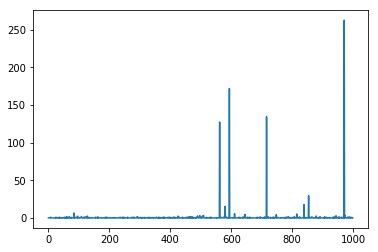

In [195]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [196]:
entropy(values)

tensor(4.4378)

In [220]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
at batch no 100
at batch no 200
at batch no 300
at batch no 400
at batch no 500
at batch no 600
at batch no 700
at batch no 800
at batch no 900
at batch no 1000
at batch no 1100
at batch no 1200
at batch no 1300
at batch no 1400
at batch no 1500
at batch no 1600
at batch no 1700
at batch no 1800
at batch no 1900
at batch no 2000
at batch no 2100
at batch no 2200
at batch no 2300
at batch no 2400
at batch no 2500
at batch no 2600
at batch no 2700
at batch no 2800
at batch no 2900
at batch no 3000
at batch no 3100
finished creating histogram for the 0th perturbation
at batch no 0
at batch no 100
at batch no 200
at batch no 300
at batch no 400
at batch no 500
at batch no 600
at batch no 700
at batch no 800
at batch no 900
at batch no 1000
at batch no 1100
at batch no 1200
at batch no 1300
at batch no 1400
at batch no 1500
at batch no 1600
at batch no 1700
at batch no 1800
at batch no 1900
at batch no 2000
at batch no 2100
at batch no 2200
at batch no 2300
at batch no 2400
at

(364,
 [(716, 11163.70),
  (971, 10571.70),
  (594, 8100.60),
  (562, 4444.20),
  (580, 1061.40),
  (854, 959.80),
  (839, 686.60),
  (611, 477.70),
  (815, 368.80),
  (497, 329.60),
  (84, 287.50),
  (646, 283.60),
  (748, 218.60),
  (509, 138.20),
  (645, 133.30),
  (425, 121.40),
  (944, 118.90),
  (824, 107.50),
  (582, 104.80),
  (973, 104.30),
  (721, 90.20),
  (489, 86.80),
  (687, 79.00),
  (879, 76.50),
  (116, 76.00),
  (800, 72.30),
  (737, 61.60),
  (907, 58.90),
  (688, 57.10),
  (709, 56.70),
  (808, 56.50),
  (946, 56.50),
  (109, 54.90),
  (621, 54.40),
  (128, 54.20),
  (679, 54.20),
  (354, 53.20),
  (788, 52.40),
  (459, 51.90),
  (955, 50.60),
  (992, 50.30),
  (476, 49.20),
  (912, 49.10),
  (735, 48.80),
  (581, 46.70),
  (411, 46.40),
  (880, 46.30),
  (741, 44.40),
  (987, 44.20),
  (936, 44.10),
  (533, 43.50),
  (892, 43.40),
  (917, 41.90),
  (468, 41.40),
  (136, 40.70),
  (904, 39.80),
  (300, 39.70),
  (790, 39.00),
  (791, 38.30),
  (506, 38.10),
  (155, 

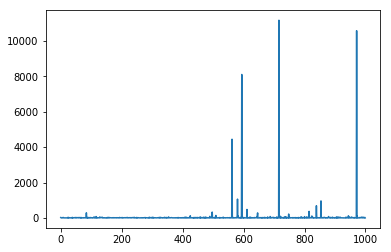

In [221]:
# on test
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [222]:
# on test
entropy(values)

tensor(4.7739)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)